# ДЗ № 6
Нахождение собственных значений

In [1]:
from typing import Generator, Tuple

import numpy as np

In [2]:
class EigValsSearcher:
    def __init__(self, A: np.ndarray, eps: float, next_el_search: str = 'simple', max_iterations=5000):
        self.A = A
        self.A_k = A.copy()
        self.n = A.shape[0]
        self.eps = eps
        self.max_iter = max_iterations
        self.error_trace = []
        self.indices = self.get_indices_generator(next_el_search)
        self.answer = self.iterative_process()

    def iterative_process(self) -> np.ndarray:
        error = self.current_error()
        self.error_trace.append(error)
        while error > self.eps:
            self._step()
            error = self.current_error()
            self.error_trace.append(error)
            if self.n_iterations > self.max_iter:
                break
        return np.diag(self.A_k)

    def _step(self):
        i, j = next(self.indices)
        T = self._generate_T(i, j)
        self.A_k = T @ self.A_k @ T.T

    def _generate_T(self, i, j):
        x = -2 * self.A_k[i, j]
        y = self.A_k[i, i] - self.A_k[j, j]

        cos_phi = sin_phi = 1 / np.sqrt(2)

        if y != 0:
            xy_sqrt = np.sqrt(x ** 2 + y ** 2)
            cos_phi = np.sqrt(0.5 * (1 + abs(y) / xy_sqrt))
            sin_phi = 0.5 * np.sign(x * y) * abs(x) / (cos_phi * xy_sqrt)

        T = np.eye(self.n)
        T[i, i] = cos_phi
        T[i, j] = - sin_phi
        T[j, i] = sin_phi
        T[j, j] = cos_phi

        return T

    def get_indices_generator(self, method: str) -> Generator[Tuple[int, int], None, None]:
        if method == 'simple':
            return self.get_next_by_order()
        elif method == 'max':
            return self.get_next_by_max()
        else:
            raise ValueError(f'No method with name: {method}')

    def get_next_by_order(self) -> Generator[Tuple[int, int], None, None]:
        while True:
            for i in range(1, self.n):
                for j in range(i):
                    yield i, j

    def get_next_by_max(self) -> Generator[Tuple[int, int], None, None]:
        mask = np.eye(self.n)
        mask[np.triu_indices_from(mask)] = 1
        while True:
            A_masked: np.ma.MaskedArray = np.ma.array(np.abs(self.A_k), mask=mask)
            i, j = np.unravel_index(A_masked.argmax(), A_masked.shape)
            yield i, j

    def current_error(self) -> float:
        return max([self.get_Gershgorin_circle(i) for i in range(self.n)])

    def get_Gershgorin_circle(self, i) -> float:
        return np.sum(np.abs(self.A_k[i, :])) - abs(self.A_k[i, i])

    @property
    def n_iterations(self):
        return len(self.error_trace)

## Тестирование

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.linalg import hilbert

from tqdm import tqdm

In [4]:
def mean_absolute_error(x: np.ndarray, y: np.ndarray) -> float:
    N = x.shape[0]
    return np.sum(np.abs(x - y)) / N

In [5]:
def prepare_data(min_N=3, max_N=50, eps=10 ** (-15)):
    simple_iter, max_iter = [], []
    simple_err, max_err = [], []
    for N in tqdm(range(min_N, max_N), desc='Preparing data'):
        H = hilbert(N)

        simple_method = EigValsSearcher(H, eps, next_el_search='simple')
        max_method = EigValsSearcher(H, eps, next_el_search='max')

        simple_iter.append(simple_method.n_iterations)
        max_iter.append(max_method.n_iterations)

        np_eigvals = np.sort(np.linalg.eigvals(H))
        simple_err.append(mean_absolute_error(np_eigvals, np.sort(simple_method.answer)))
        max_err.append(mean_absolute_error(np_eigvals, np.sort(max_method.answer)))

    return simple_iter, max_iter, simple_err, max_err

def plot_comparison(data: tuple, min_N=3, max_N=50):
    simple_iter, max_iter, simple_err, max_err = data

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(14, 4.5)

    X = range(min_N, max_N)

    axes[0].set_title('Количество итераций')
    sns.lineplot(x=X, y=simple_iter, label='Выбор нумерацией', ax=axes[0])
    sns.lineplot(x=X, y=max_iter, label='Выбор максимума', ax=axes[0], color='orange')

    axes[1].set_title('Средняя абсолютная ошибка')
    sns.lineplot(x=X, y=simple_err, label='Выбор нумерацией', ax=axes[1])
    sns.lineplot(x=X, y=max_err, label='Выбор максимума', ax=axes[1], color='orange').set(yscale='log')

    fig.tight_layout()
    plt.show()

In [6]:
data = prepare_data()

Preparing data: 100%|██████████| 47/47 [00:33<00:00,  1.41it/s]


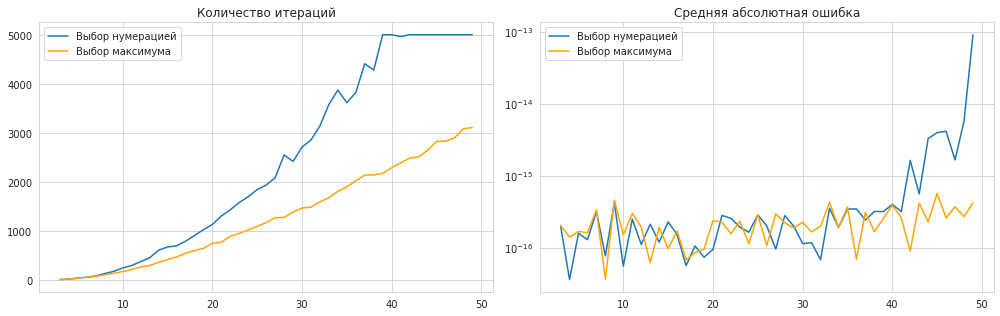

In [7]:
plot_comparison(data)

In [54]:
%timeit EigValsSearcher(hilbert(30), 10**(-15), 'simple')

364 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit EigValsSearcher(hilbert(30), 10**(-15), 'max')

250 ms ± 3.54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
